# Ellipses

In [ ]:
using Plots
using Random
using StatsBase
using LinearAlgebra
using Printf
using Revise

In [ ]:
Revise.includet("ellipses/src/ellipse.jl")
Revise.includet("ellipses/src/eigenvalues.jl")

In [ ]:
using PolygonAlgorithms: area_polygon
using PolygonAlgorithms: matrix_to_points

### Basics

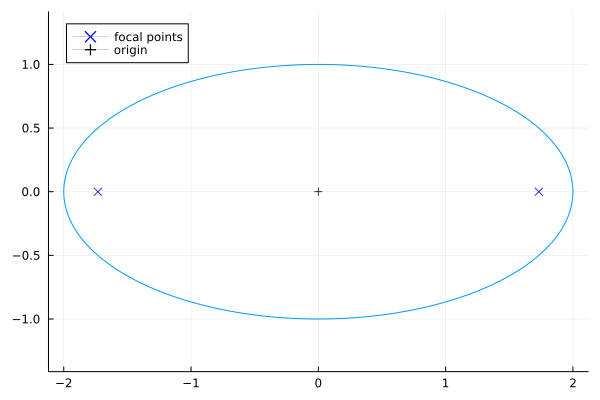

In [ ]:
a, b, θ, origin = 2.0, 1.0, 0 * π / 180, [0.0; 0.0]
X_ellipse = make_ellipse(a, b, θ, origin)
plot(X_ellipse[1, :], X_ellipse[2, :], aspectratio=:equal; label="")
c = sqrt(a^2 - b^2)
R = make_rotation_matrix(θ)
focal_points = R * [-c c; 0 0] .+ origin
plot!(focal_points[1, :], focal_points[2, :], color=:blue, marker=:x, linewidth=0, label="focal points")
plot!([0], [0], color=:black, marker=:cross, linewidth=0, label="origin")

## Generate data

https://www.probabilitycourse.com/chapter5/5_3_2_bivariate_normal_dist.php

The following are correlated with $r$:

$$
X = \mu_X + \sigma_X Z_1 \\
Y = \mu_Y + \sigma_Y \left(r Z_1 + \sqrt{1-r^2}Z_2 \right)
$$

In [ ]:
r = 0.6
n = 500
μ_x = 2.0
σ_x = 1.5
z1 = randn(n)
x = μ_x .+ z1 .* σ_x;

μ_y = 2.0
σ_y = 0.9

y = μ_y .+ σ_y .* (r .* z1 .+ sqrt(1 - r^2) .* randn(n));

In [ ]:
cor(x, y)

0.6004998742521004

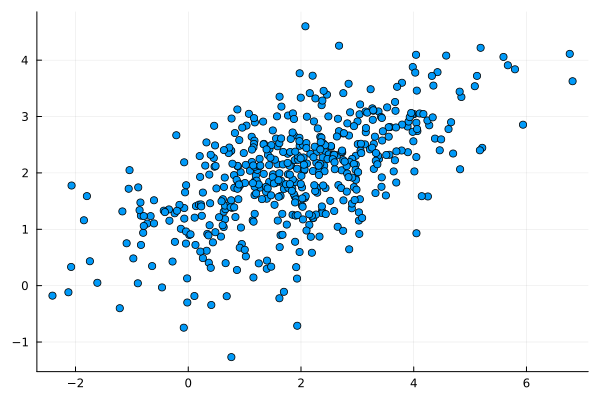

In [ ]:
scatter(x, y, aspectratio=:equal, label="")

In [ ]:
C = [
    [var(x) cov(x, y)] ;
    [cov(x, y) var(y)]
]

2×2 Matrix{Float64}:
 2.21078   0.812657
 0.812657  0.828406

## Ellipses

The eigenvalues are the solution of 
$$ 
\begin{align}
Ax &= \lambda x \\
(A-\lambda I)x &= 0 \\
\begin{bmatrix}
 a - \lambda & b \\
 c & d  - \lambda 
\end{bmatrix}
\begin{bmatrix}
x_1 \\ x_2
\end{bmatrix}
&=
\begin{bmatrix}
0 \\ 0
\end{bmatrix} 
\end{align} 
$$

which requires
$$
det(A-\lambda I) = 0 \\
\Rightarrow \lambda^2 - (a + d)\lambda + (ad - bc) = 0 \\
\therefore \lambda = \frac{1}{2}\left(a + d \pm \sqrt{(a-d)^2 + 4bc} \right)
$$

In [ ]:
function plot_vector!(base_plot, origin, v, scale; options...)
    point = origin .+ scale * v
    plot!(base_plot, [origin[1], point[1]], [origin[2], point[2]]; options...)
end

plot_vector! (generic function with 1 method)

In [ ]:
@time eigs = eigen(C);
@time eigenvalues, W = calc_eigvals_2x2(C)
display(eigs)
display(eigenvalues)
display(W)

  0.000041 seconds (11 allocations: 1.391 KiB)
  0.000094 seconds (11 allocations: 752 bytes)


Eigen{Float64, Float64, Matrix{Float64}, Vector{Float64}}
values:
2-element Vector{Float64}:
 0.4527514614217809
 2.5864339204061926
vectors:
2×2 Matrix{Float64}:
  0.419594  -0.907712
 -0.907712  -0.419594

2-element Vector{Float64}:
 0.4527514614217807
 2.5864339204061926

2×2 Matrix{Float64}:
 -0.419594  0.907712
  0.907712  0.419594

In [ ]:
x_mean = mean(x);
y_mean = mean(y);

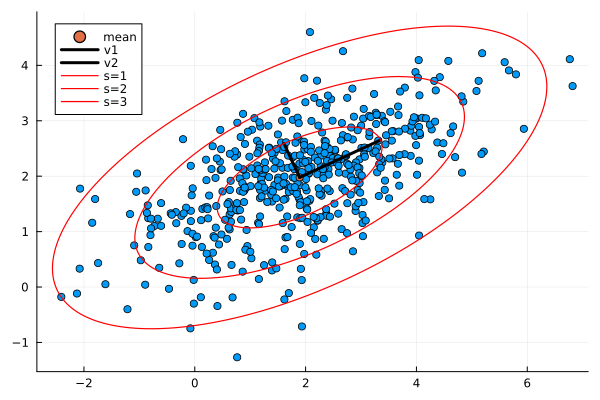

In [ ]:
base_plot = scatter(x, y, aspect=:equal, label="", aspectratio=:equal)
scatter!(base_plot, [x_mean], [y_mean], label="mean")
plot_vector!(base_plot, [x_mean, y_mean], W[:, 1], sqrt(eigenvalues[1]); linewidth=3, color=:black, label="v1")
plot_vector!(base_plot, [x_mean, y_mean], W[:, 2], sqrt(eigenvalues[2]); linewidth=3, color=:black, label="v2")

angle = atan(W[2, 1], W[1, 1])
origin = [mean(x); mean(y)]
for scale in [1, 2, 3]
    a = scale * sqrt(eigenvalues[1])
    b = scale * sqrt(eigenvalues[2])
    X_ellipse = make_ellipse(a, b, angle, origin)
    plot!(base_plot, X_ellipse[1, :], X_ellipse[2, :], aspectratio=:equal; linewidth=1.2, color=:red, label="s=$scale")
end
base_plot

## Points in ellipse

σ=2.45 0.936


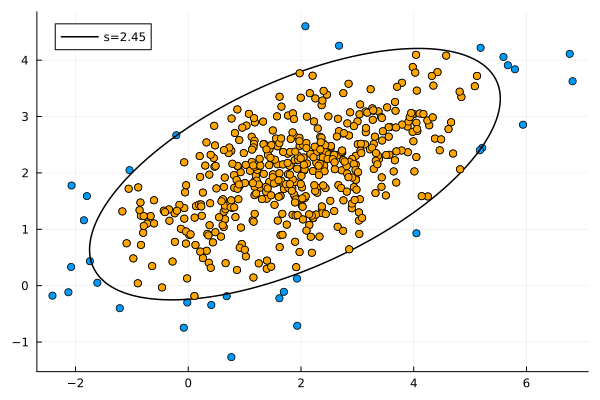

In [ ]:
scale = 2.45
points = transpose(hcat(x, y))
a = scale * sqrt(eigenvalues[1])
b = scale * sqrt(eigenvalues[2])
X_ellipse = make_ellipse(a, b, angle, origin)
inside = point_in_ellipse(points, a, b, angle, origin)
@printf("σ=%.2f %.3f\n", scale, count(inside)/length(inside)) 

scatter(x, y, aspect=:equal, label="", aspectratio=:equal)
plot!(X_ellipse[1, :], X_ellipse[2, :], aspectratio=:equal; linewidth=1.5, color=:black, label="s=$scale")
scatter!(x[inside], y[inside], aspect=:equal, label="", aspectratio=:equal, color=:orange)

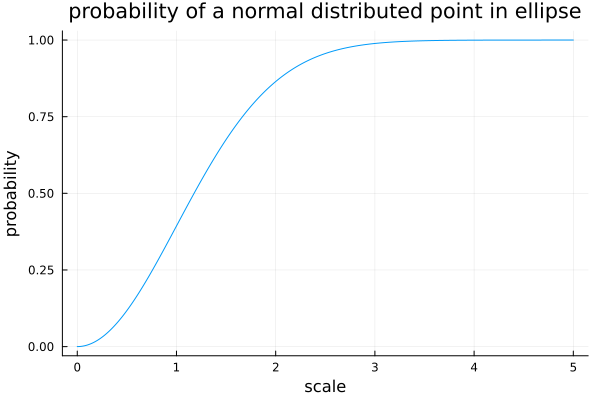

In [ ]:
cdf(r) = 1 - exp(-0.5 * r^2) # Chi-Squared cdf with k=2

r = 0:0.01:5

plot(r, cdf.(r),
    xlabel="scale",
    ylabel="probability",
    label="",
    title="probability of a normal distributed point in ellipse"
)

## Ellipse intersections

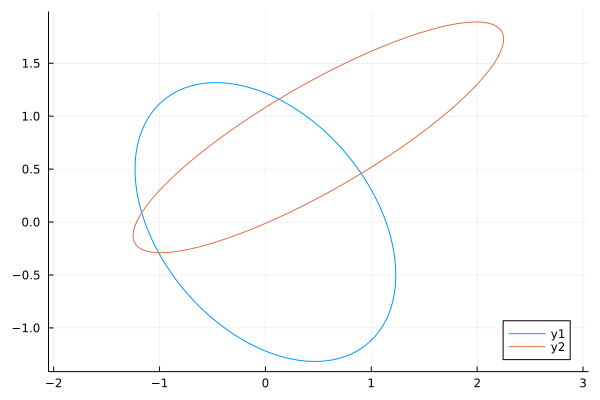

In [ ]:
a1, b1, θ1, origin1 = 1.0, 1.5, 30 * π / 180, [0.0; 0.0]
a2, b2, θ2 = 2.0, 0.5, 30 * π / 180 

#origin2 = [0.0; 0.0]              # 4 intersections
#origin2 = [cos(θ2); sin(θ2)]      # 3 intersections
#origin2 = 1.5 * [cos(θ2); sin(θ2)]   # 2 intersections
#origin2 = 3 * [cos(θ2); sin(θ2)]  # 1 intersection
#origin2 = [3.0; 0.0]              # 0 intersections

# roots outside bounds
# a1, b1, θ1, origin1 = 2.5, 1.5, 0.0, [0.0, 0.0]
# a2, b2, θ2, origin2 = 2.0, 1.0, 0.0, [0.0, 0.0] 
#a1, b1, θ1, origin1 = 2.0, 2.0, 0.0, [0.0, 0.0]
#a2, b2, θ2, origin2 = 0.5, 2.0, 0.0, [2.0, 0.0] 

## concentric
# a1, b1, θ1, origin1 = 3.0, 2.0, 0.0, [0.0, 0.0]
# a2, b2, θ2, origin2 = a1, b1, θ1, origin1 + [2; 0]
# #a2, b2, θ2, origin2 = 2.0, 4.0, 0.0, [0.0, 0.0] 

# # general
a1, b1, θ1, origin1 = 1.0, 1.5, 40 * π / 180, [0.0, 0.0]
a2, b2, θ2, origin2 = 2.0, 0.5, 30 * π / 180, [0.5, 0.8]

#a2, b2, θ2, origin2 = a1, b1, θ1, origin1

X1 = make_ellipse(a1, b1, θ1, origin1)
X2 = make_ellipse(a2, b2, θ2, origin2)

plot_inter = plot(X1[1, :], X1[2, :], aspectratio=:equal)
plot!(plot_inter, X2[1, :], X2[2, :], aspectratio=:equal)

In [ ]:
area_inter = ellipses_intersect_area(a1, b1, θ1, origin1, a2, b2, θ2, origin2)

1.5907413076401071

In [ ]:
@time intersection_points, multiplicity = intersect_ellipses(a1, b1, θ1, origin1, a2, b2, θ2, origin2)
display(intersection_points)
@show multiplicity;

  0.000125 seconds (90 allocations: 7.250 KiB)


2×4 Matrix{Float64}:
 -1.0086    -1.16807    0.90496   0.126557
 -0.289496   0.0883537  0.458799  1.16026

multiplicity = [1, 1, 1, 1]


(-1.0085990121875534 - 2.2691864496337705e-17im, -1.1680698134063112 + 1.8366121352631394e-17im, 0.904959990238142 - 2.5456393308893526e-18im, 0.12655700259916447 + 6.8713824745956624e-18im)


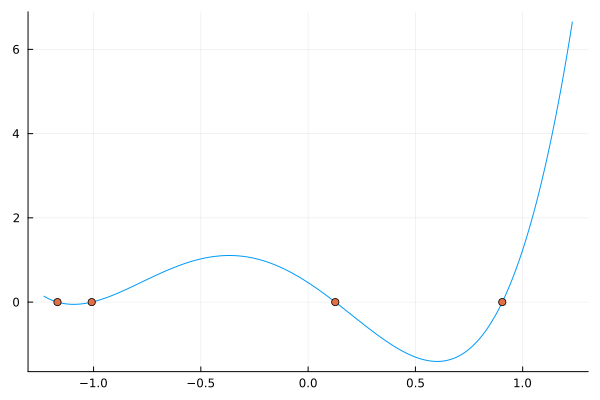

In [ ]:
coeffs1 = conic_coefficients(a1, b1, θ1, origin1)
coeffs2 = conic_coefficients(a2, b2, θ2, origin2)
f = quartic_coefficients(coeffs1, coeffs2)
println(solve_quartic_eq(f))
x_e = X1[1, :]
errors = f[1] .+ f[2] * x_e + f[3] * x_e.^2 + f[4] * x_e.^3 + f[5] * x_e.^4
error_plot = plot(x_e, errors, label="")
if !isempty(intersection_points)
    scatter!(intersection_points[1, :], zeros(size(intersection_points, 2)), label="")
end
error_plot

In [ ]:
idxs_1in2 = point_in_ellipse(X1, a2, b2, θ2, origin2)
@printf("1 in 2: %.2f%%\n", count(idxs_1in2) / length(idxs_1in2) * 100)

idxs_2in1 = point_in_ellipse(X2, a1, b1, θ1, origin1)
@printf("2 in 1: %.2f%%", count(idxs_2in1) / length(idxs_2in1) * 100)

intersection = hcat(X1[:, idxs_1in2], X2[:, idxs_2in1], intersection_points);

1 in 2: 16.20%
2 in 1: 36.80%

In [ ]:
function order_points_clockwise(points::Matrix)
    centroid = sum(points, dims=2) / size(points, 2)
    angles = atan.(points[2, :] .- centroid[2], points[1, :] .- centroid[1])
    idxs = sortperm(angles)
    points[:, idxs]
end

function ellipses_intersect_area_approx(
    a1::T, b1::T, θ1::T, o1::Vector{T},
    a2::T, b2::T, θ2::T, o2::Vector{T}
    ; length=1000
    ) where T
    R1 = make_rotation_matrix(θ1)
    X1 = make_ellipse(a1, b1, R1, o1, length=length)
    R2 = make_rotation_matrix(θ2)
    X2 = make_ellipse(a2, b2, R2, o2, length=length)

    idxs_1in2 = point_in_ellipse(X1, a2, b2, θ2, o2)
    idxs_2in1 = point_in_ellipse(X2, a1, b1, θ1, o1)
    intersection = hcat(X1[:, idxs_1in2], X2[:, idxs_2in1]);
    
    X_inside = order_points_clockwise(intersection)
    points = matrix_to_points(X_inside)
    area = area_polygon(points)
    area
end

ellipses_intersect_area_approx (generic function with 1 method)

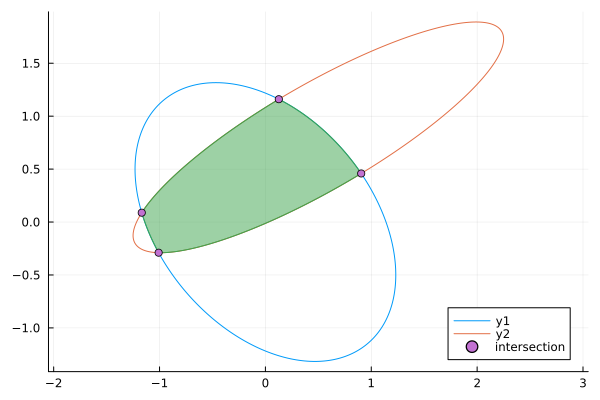

In [ ]:
X_inside = order_points_clockwise(intersection)
if !isempty(intersection)
    idxs = vcat(1:size(X_inside, 2), 1)
    plot!(plot_inter, X_inside[1, idxs], X_inside[2, idxs], fill = (true, 0.5), label="")
    scatter!(plot_inter, intersection_points[1, :], intersection_points[2, :], label="intersection")
end

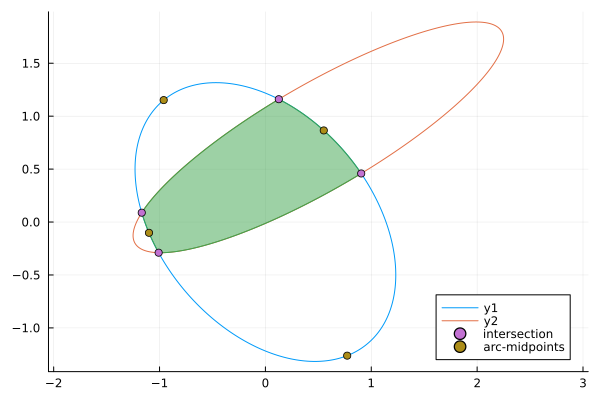

In [ ]:
angles = points_to_angles(intersection_points, a1, b1, θ1, origin1)
idxs = sortperm(angles)
angles = angles[idxs]
points = intersection_points[:, idxs]

n = size(points, 2)
mids = zeros(2, n)
for i in 1:n
    mids[:, i] = arc_midpoint(points[:, [i, i % n + 1]], a1, b1, θ1, origin1)
end

scatter!(plot_inter, mids[1, :], mids[2, :], label="arc-midpoints")

In [ ]:
points1 = matrix_to_points(X1)
points2 = matrix_to_points(X2)

area1 = π * a1 * b1
area1_approx = area_polygon(points1)
area2 = π * a2 * b2
area2_approx = area_polygon(points2)
@time area_inter_approx = ellipses_intersect_area_approx(a1, b1, θ1, origin1, a2, b2, θ2, origin2; length=1000)
@time area_inter = ellipses_intersect_area(a1, b1, θ1, origin1, a2, b2, θ2, origin2)

IoU_approx =  area_inter_approx / (area1_approx + area2_approx - area_inter_approx)
IoU =  area_inter / (area1 + area2 - area_inter)

@printf("Area of 1: %.4f %.4f\n", area1, area1_approx)
@printf("Area of 2: %.4f %.4f\n", area2, area2_approx)
@printf("Area of intersection: %.4f %.4f\n", area_inter, area_inter_approx)
@printf("IoU : %.4f %.4f\n", IoU, IoU_approx)
@printf("error in approximation 1: %.4f%%\n", (area1_approx - area1)/area1 * 100)
@printf("error in approximation 2: %.4f%%\n", (area2_approx - area2)/area2 * 100)
@printf("error in approximation inter: %.4f%%\n", (area_inter_approx - area_inter)/area_inter * 100)
@printf("error in IoU: %.4f%%\n", (IoU_approx - IoU)/IoU * 100)

  0.035989 seconds (21.35 k allocations: 1.332 MiB, 98.34% compilation time)
  0.000078 seconds (292 allocations: 23.000 KiB)
Area of 1: 4.7124 4.7124
Area of 2: 3.1416 3.1416
Area of intersection: 1.5907 1.5907
IoU : 0.2540 0.2540
error in approximation 1: -0.0007%
error in approximation 2: -0.0007%
error in approximation inter: -0.0038%
error in IoU: -0.0040%
